In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.utils.data
import torch.optim as optim
import torch.nn.functional as F
import os
import math


from torch import nn
from pydub import AudioSegment
from scipy.signal import detrend

In [2]:
sampling_rate = 4096
chunks_per_sec = 60
chunk_sample_len = sampling_rate // chunks_per_sec

In [3]:
# magnitude extractor
def magnitude_extractor(x, N):
    return 20 * np.log10(np.sqrt(np.real(x) ** 2 + np.imag(x) ** 2) / chunk_sample_len + 1)

def read_audio_source(file_name):
    if(file_name.endswith((".flac", ".wav"))):
        raw = AudioSegment.from_file(file_name)
    else: raw = AudioSegment.from_mp3(file_name)
    
    raw = raw.set_channels(1)
    raw = raw.set_frame_rate(sampling_rate)

    data = raw.get_array_of_samples()
    data = np.array(data)

    chunk_count = len(data) // chunk_sample_len

    data = data[:chunk_count * chunk_sample_len].reshape(-1, chunk_sample_len)

    # kaiser window 
    window = np.kaiser(chunk_sample_len, beta = 13)

    data = data * window
    
    N = chunk_sample_len // 2

    data = magnitude_extractor(np.fft.fft(data)[:, :N], 1)
    bins = np.fft.fftfreq(chunk_sample_len, 1 / sampling_rate)[:N]
    
    return (data, bins)

def chunk_plot(x_input, y_input):
    fig = plt.figure(figsize = (25, 4))
    
    for index, input in enumerate(y_input):
        ax = fig.add_subplot(1, 6, index + 1)
        ax.plot(x_input, input)
        ax.set_xlabel('Frequency (kHz)')
        ax.set_ylabel('Power (dB)')

In [4]:
def get_files():
    root = "dataset\\data"
    dirs = os.listdir(root)

    raw = []
    
    for directory in dirs:
        for sub_dir in os.listdir(root + "\\" + directory):
            current_file = ""

            curr_dir = root + "\\" + directory + "\\" + sub_dir
            for file in os.listdir(curr_dir):
                if(file.endswith(".txt")):
                    current_file = file

                    break

            with open(curr_dir + "\\" + current_file, "r") as ins:
                for line in ins:
                    match = line.split(" ", 1)
                    match[0], match[1] = curr_dir + "\\" + match[0] + ".flac", match[1][:-1]

                    raw.append(match)
                
    return raw

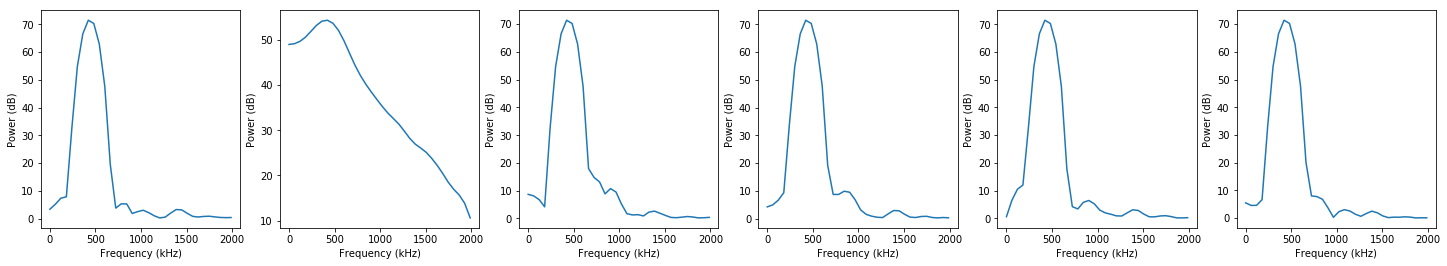

In [5]:
data, bins = read_audio_source("test\\MidTone.mp3")
chunk_plot(bins, data[[15, 1, 2, 3, 4, 25]])

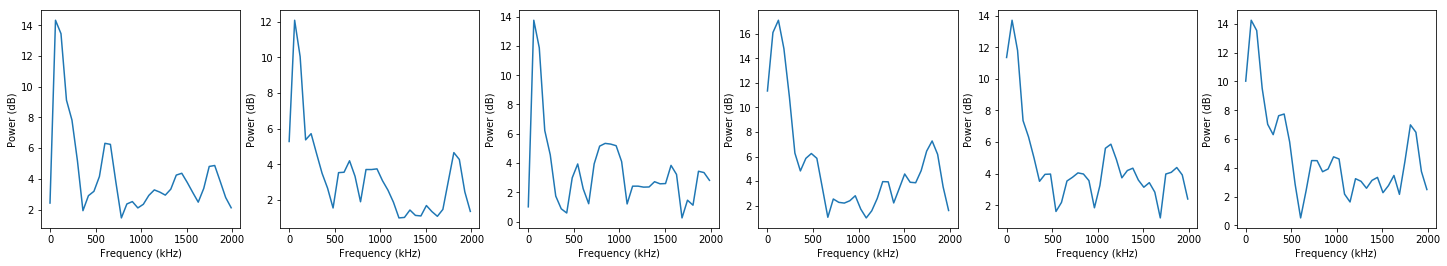

In [6]:
raw = get_files()

data, bins = read_audio_source(raw[0][0])

chunk_plot(bins, data[[0, 1, 2, 3, 4, 5]])

In [7]:
def encode_text(input, size):
    output = np.zeros(size)
    
    input_size = len(input)
    
    min_r = size // input_size
    max_r = min_r + 1
    
    max_r_count = size - min_r * input_size
    min_r_count = input_size - max_r_count    
    
    ch = 0
    it = 0
    while(it != size):
        rng = min_r
        if(max_r_count >= min_r_count):
            rng = max_r
            max_r_count -= 1
        else: min_r_count -= 1
            
        for i in range(rng):
            output[it] = ord(input[ch])
            it += 1
            
        ch += 1
        
    return output

In [8]:
print(encode_text("abcd", 13))

[ 97.  97.  97.  98.  98.  98.  99.  99.  99.  99. 100. 100. 100.]


In [107]:
raw = get_files()

dataset = []
seq_max = 0
for (file, trans) in raw:
    data, _ = read_audio_source(file)
    
    data_t = encode_text(trans, len(data))
    
    seq_max = max(seq_max, len(data))
    
    dataset.append([data, data_t])

features_padded = []
targets_padded = []
for (data, data_t) in dataset:
    res_padded = np.zeros((seq_max, data.shape[1]), dtype = np.float32)
    res_padded_t = np.zeros(seq_max) + 32
    
    res_padded[:data.shape[0], :] = data
    res_padded_t[:data_t.shape[0]] = data_t
    
    features_padded.append(res_padded)
    targets_padded.append(res_padded_t)
    
features_data = np.concatenate(features_padded)
targets_data = np.concatenate(targets_padded)

unique_ch = np.unique(targets_data)
alphabet = { ch : index for index, ch in enumerate(unique_ch) }
alphabet_h = { index : ch for index, ch in enumerate(unique_ch) }

for index in range(len(targets_data)):
    targets_data[index] = alphabet[targets_data[index]]

In [ ]:
raw = get_files()

features = []
targets = []

seq_max = 0
for (file, trans) in raw:
    data, _ = read_audio_source(file)
    
    data_t = [ ord(ch) for ch in trans ]
    
    seq_max = max(seq_max, len(data))
    
    features.append(data)
    targets.append(data_t)

features_padded = []
for feature in features:
    res_padded = np.zeros((seq_max, feature.shape[1]), dtype = np.float32)
    
    res_padded[:feature.shape[0], :] = feature
    
    features_padded.append(res_padded)
    
features = np.concatenate(features_padded)

unique_ch = list(set(x for l in targets for x in l))

alphabet = { ch : index for index, ch in enumerate(unique_ch) }
alphabet_h = { index : ch for index, ch in enumerate(unique_ch) }

for target in targets:
    for index in range(len(target)):
        target[index] = alphabet[target[index]]

In [108]:
def get_text(input):
    return "".join([ chr(int(alphabet_h[int(x)])) for x in input ])

In [109]:
print(seq_max)
print(len(unique_ch))
print(features[0:1000])
print(features[2104:2400])

2105
28
[[ 2.4201205 14.331686  13.45716   ...  3.8344696  2.7787137  2.1129775]
 [ 5.2746334 12.094499  10.048386  ...  4.2636847  2.4402895  1.3425461]
 [ 1.008129  13.750992  11.871043  ...  3.4378364  3.3489652  2.8173811]
 ...
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]]
[[ 0.        0.        0.       ...  0.        0.        0.      ]
 [19.155964 19.372107 15.687551 ... 11.015881 13.066073 11.450277]
 [19.783312 19.978268 17.392265 ...  9.519546 10.059752  7.313766]
 ...
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]]


In [132]:
batch_size = 25

# features_data = features_data[:seq_max * batch_size]
batch_count = int((len(features) / seq_max) // batch_size)

features = features[:int(batch_count * batch_size * seq_max)]
targets = targets[:int(batch_count * batch_size)]

train_loader = torch.from_numpy(features).view(batch_count, batch_size, seq_max, -1)

print(train_loader[0])

tensor([[[ 2.4201, 14.3317, 13.4572,  ...,  3.8345,  2.7787,  2.1130],
         [ 5.2746, 12.0945, 10.0484,  ...,  4.2637,  2.4403,  1.3425],
         [ 1.0081, 13.7510, 11.8710,  ...,  3.4378,  3.3490,  2.8174],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[19.1560, 19.3721, 15.6876,  ..., 11.0159, 13.0661, 11.4503],
         [19.7833, 19.9783, 17.3923,  ...,  9.5195, 10.0598,  7.3138],
         [14.5445, 14.0697,  6.9836,  ..., 12.2072,  6.6720,  4.3743],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[18.6906, 19.1262, 17.3564,  ...,  3.2350,  2.9702,  3.4719],
         [18.1225, 17.7602, 14.3689,  ...,  7

In [133]:
class Network(nn.Module):
    def __init__(self, input_size, output_size, n_layers):
        super(Network, self).__init__()
        
        self.hidden_size = output_size
        
        self.rnn = nn.RNN(input_size, output_size, n_layers, batch_first = True)
        
        # fully connected layer
        self.fc = nn.Linear(self.hidden_size, 28)
        
        # dropout layer
        self.dropout = nn.Dropout(p = 0.15)
        
    def forward(self, x, hidden):
        # x & output (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_size)
        # r_out (batch_size, time_step, hidden_size)
        r_out, hidden = self.rnn(x, hidden)
        
        # shape output to be (batch_size * seq_length, hidden_size)
        r_out = r_out.contiguous().view(-1, self.hidden_size)  
        
        # pass through dropout layer
        r_out = self.dropout(r_out)
        
        # our connected layer
        output = self.fc(r_out)
    
        return output, hidden

In [ ]:
def decoder(input):
    return "".join([ chr(int(alphabet_h[int(x)])) for x in input ])

In [18]:
import time

# testing model
test = Network(34, seq_max, n_layers = 2)

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.ASGD(test.parameters(), lr = 0.01)

print(len(train_loader))

# generate test data
input_dt, targets_dt = next(iter(train_loader))

print('Targets size: ', targets_dt.size())

print(input_dt.view(batch_size, seq_max, -1).shape)

start = time.time()

test_out, test_h = test(input_dt.view(batch_size, seq_max, -1), None)

loss = criterion(test_out, targets_dt.type(dtype = torch.LongTensor))

# backwards pass
loss.backward()

# adjusting the weigths
optimizer.step()

end = time.time()

print("Elapsed time: ", end - start)

print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

105
Targets size:  torch.Size([52625])
torch.Size([25, 2105, 34])


KeyboardInterrupt: 

In [137]:
# our model
model = Network(34, seq_max, n_layers = 2)

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.ASGD(model.parameters(), lr = 0.04)

In [140]:
# number of epochs for model' training
epochs_count = 15

for g in optimizer.param_groups:
    g['lr'] = 0.05

test_loss_min = np.Inf

for epoch in range(1, epochs_count + 1):
    
    train_loss = 0.0
    
    hidden_train = None
    
    model.train()
    for features, targets in train_loader:
        # gradients clear
        optimizer.zero_grad()
    
        # forward pass
        output, hidden_train = model(features.view(batch_size, seq_max, -1), hidden_train)
        
        hidden_train = hidden_train.data
        
        loss = criterion(output, targets.type(dtype = torch.LongTensor))
        
        # backwards pass
        loss.backward()
        
        # adjusting the weigths
        optimizer.step()
        
        # update training loss
        train_loss += loss.item() * features.size(0)
        
    
    # calculate average losses
    train_loss = train_loss / len(train_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, test_loss))

ValueError: too many values to unpack (expected 2)

In [101]:
features, targets = next(iter(train_loader))

output, hidden_t = model(features, None)

# print(get_text(targets))
print(output)
print(output.view(-1, 28))
print(torch.exp(F.log_softmax(output[0])))
print(criterion(torch.exp(F.log_softmax(output[0])), targets[0].view(1).type(torch.LongTensor)))
print(criterion(output[0], targets[0].view(1).type(torch.LongTensor)))


print(criterion(torch.from_numpy(np.array([[0.7, 0.3], [0.3, 0.7]])), torch.from_numpy(np.array([0, 1])).type(torch.LongTensor)))

tensor([[[0.0622, 0.0296, 0.0000,  ..., 0.1543, 0.0000, 0.1591]],

        [[0.0000, 0.0296, 0.2292,  ..., 0.1544, 0.1274, 0.1592]],

        [[0.0000, 0.0296, 0.2294,  ..., 0.1544, 0.1275, 0.0000]],

        ...,

        [[0.0623, 0.0296, 0.0000,  ..., 0.0000, 0.1273, 0.1592]],

        [[0.0623, 0.0296, 0.0000,  ..., 0.1543, 0.0000, 0.1592]],

        [[0.0623, 0.0296, 0.2293,  ..., 0.1543, 0.1273, 0.1592]]],
       grad_fn=<DropoutBackward>)
tensor([[0.0622, 0.0296, 0.0000,  ..., 0.1543, 0.0000, 0.1591],
        [0.0000, 0.0296, 0.2292,  ..., 0.1544, 0.1274, 0.1592],
        [0.0000, 0.0296, 0.2294,  ..., 0.1544, 0.1275, 0.0000],
        ...,
        [0.0623, 0.0296, 0.0000,  ..., 0.0000, 0.1273, 0.1592],
        [0.0623, 0.0296, 0.0000,  ..., 0.1543, 0.0000, 0.1592],
        [0.0623, 0.0296, 0.2293,  ..., 0.1543, 0.1273, 0.1592]],
       grad_fn=<ViewBackward>)
tensor([[0.0359, 0.0348, 0.0337, 0.0347, 0.0358, 0.0411, 0.0337, 0.0337, 0.0337,
         0.0337, 0.0337, 0.0349, 0.0337,

C:\Users\Cchiv\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  
C:\Users\Cchiv\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':
